In [74]:
import numpy as np
import pandas as pd

# os.walk是用来递归遍历某个目录，并区分出该目录下的子文件夹和子文件的函数
# 每次遍历返回一个三元组，当前文件夹路径，当前文件夹中所有子文件夹名称列表，当前文件夹中所有文件的名称列表
# 遍历的顺序为：父文件夹->子文件夹，子文件夹之间具体的顺序由文件系统决定
import os
datapath = '/home/xiangyu/kaggle/fashionmnist/data/'
for dirname, _, filenames in os.walk(datapath):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/home/xiangyu/kaggle/fashionmnist/data/fashion-mnist_test.csv
/home/xiangyu/kaggle/fashionmnist/data/t10k-images-idx3-ubyte
/home/xiangyu/kaggle/fashionmnist/data/fashion-mnist_train.csv
/home/xiangyu/kaggle/fashionmnist/data/train-images-idx3-ubyte
/home/xiangyu/kaggle/fashionmnist/data/t10k-labels-idx1-ubyte
/home/xiangyu/kaggle/fashionmnist/data/train-labels-idx1-ubyte


In [75]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

In [76]:
train = pd.read_csv(os.path.join(datapath, 'fashion-mnist_train.csv'))
test = pd.read_csv(os.path.join(datapath, 'fashion-mnist_test.csv'))

In [77]:
label_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [78]:
# 这一段和下面一段纯是为了画画用的
X_train = train.drop(['label'], axis=1)
y_train = train['label']
X_test = test.drop(['label'], axis=1)
y_test = test['label']

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

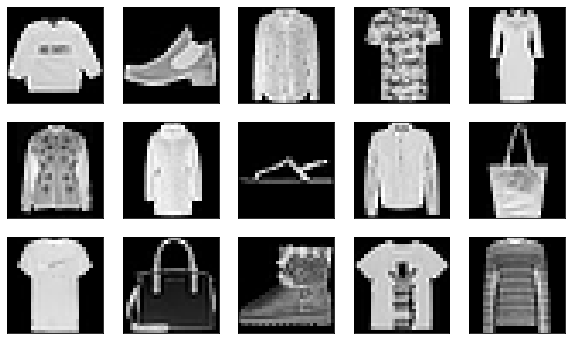

In [79]:
# DataFrame类型的value返回的是一个二维Numpy数组，因此可以reshape
X_train = X_train.values.reshape(-1, 28, 28)
X_test = X_test.values.reshape(-1, 28, 28)

# plt.subplots创建三行五列的子图，figsize的单位是英寸，返回值中fig是整个图表对象，ax是子图对象
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
# flat获得ax对象的一维扁平版本
for i, axi in enumerate(ax.flat):
    # imshow是专门显示图像的函数，一般要先利用matplotlib.image.mping的imread来打开一个jpg图像，然后传给imshow，但看来直接传数组也可以
    axi.imshow(X_train[i], cmap='gray')  
    # 两个ticks表示的是x和y轴的刻度，因为默认值是有的，所以这里是给设成没有了
    axi.set(xticks=[], yticks=[])
    # 设置x轴为分类名字，并设置x轴颜色（因为我背景是黑的）
    axi.set_xlabel(label_names[y_train.iloc[i]], color='white')
plt.show()

In [105]:
class FashionDataset(Dataset):
    def __init__(self, data:pd.DataFrame, device):
        super(FashionDataset, self).__init__()
        # axis表示具体是删除行还是删除列，0表示行，1表示列
        self.x = torch.tensor(data.drop(['label'], axis=1).values, dtype=torch.float32).to(device)
        self.y = torch.tensor(data['label'].values, dtype=torch.int64).to(device)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

In [121]:
class FashionClassifier(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(FashionClassifier, self).__init__()
        hidden = 1024
        self.l1 = nn.Linear(num_inputs, hidden)
        self.l2 = nn.Linear(hidden, hidden)
        self.l3 = nn.Linear(hidden, hidden)
        self.l4 = nn.Linear(hidden, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 模型的最后输出不需要softmax原因是softmax不改变顺序
        return self.l4(self.relu(self.l3(self.relu(self.l2(self.relu(self.l1(x)))))))

In [122]:
class Trainer:
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train_step(self, inputs, targets):
        self.model.train()
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_epoch(self, dataloader):
        total_loss = 0.0
        num_batches = len(dataloader)
        for inputs, targets in dataloader:
            loss = self.train_step(inputs=inputs, targets=targets)
            total_loss += loss
        return total_loss / num_batches
    
    def train(self, dataloader, num_epoches):
        for epoch in range(num_epoches):
            epoch_loss = self.train_epoch(dataloader=dataloader)
            print(f"Epoch {epoch + 1}/{num_epoches}, Loss: {epoch_loss:.4f}")

    def test_step(self, inputs, targets):
        self.model.eval()
        outputs = self.model(inputs)
        max_arg = torch.argmax(outputs, dim=-1)
        res = (max_arg == targets).sum() / len(max_arg)
        return res

    def test(self, dataloader):
        total_loss = 0.0
        num_batches = len(dataloader)
        for inputs, targets in dataloader:
            loss = self.test_step(inputs=inputs, targets=targets)
            total_loss += loss
        return total_loss / num_batches

In [123]:
device = 'cuda:1'

In [124]:
trainset = FashionDataset(train, device)
testset = FashionDataset(test, device)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128)

In [125]:
model = FashionClassifier(num_inputs=28*28, num_outputs=len(label_names)).to(device=device)
trainer = Trainer(model=model, optimizer=optim.SGD(params=model.parameters(), lr=0.001), criterion=nn.CrossEntropyLoss())

In [126]:
trainer.train(trainloader, 50)

Epoch 1/50, Loss: 0.7588
Epoch 2/50, Loss: 0.4063
Epoch 3/50, Loss: 0.3627
Epoch 4/50, Loss: 0.3366
Epoch 5/50, Loss: 0.3144
Epoch 6/50, Loss: 0.2968
Epoch 7/50, Loss: 0.2833
Epoch 8/50, Loss: 0.2693
Epoch 9/50, Loss: 0.2560
Epoch 10/50, Loss: 0.2465
Epoch 11/50, Loss: 0.2376
Epoch 12/50, Loss: 0.2267
Epoch 13/50, Loss: 0.2191
Epoch 14/50, Loss: 0.2102
Epoch 15/50, Loss: 0.2037
Epoch 16/50, Loss: 0.1967
Epoch 17/50, Loss: 0.1881
Epoch 18/50, Loss: 0.1808
Epoch 19/50, Loss: 0.1759
Epoch 20/50, Loss: 0.1689
Epoch 21/50, Loss: 0.1642
Epoch 22/50, Loss: 0.1573
Epoch 23/50, Loss: 0.1525
Epoch 24/50, Loss: 0.1469
Epoch 25/50, Loss: 0.1423
Epoch 26/50, Loss: 0.1365
Epoch 27/50, Loss: 0.1325
Epoch 28/50, Loss: 0.1265
Epoch 29/50, Loss: 0.1226
Epoch 30/50, Loss: 0.1185
Epoch 31/50, Loss: 0.1135
Epoch 32/50, Loss: 0.1082
Epoch 33/50, Loss: 0.1077
Epoch 34/50, Loss: 0.1024
Epoch 35/50, Loss: 0.0983
Epoch 36/50, Loss: 0.0947
Epoch 37/50, Loss: 0.0900
Epoch 38/50, Loss: 0.0875
Epoch 39/50, Loss: 0.

In [127]:
test_loss = trainer.test(testloader)
print(test_loss)

tensor(0.8940, device='cuda:1')


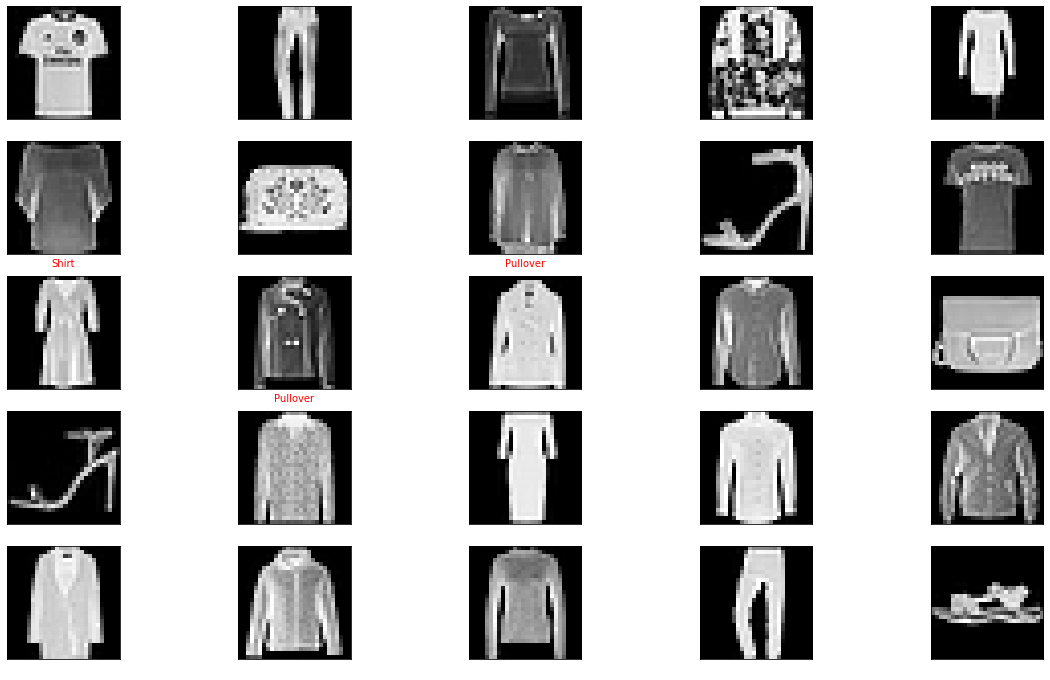

In [128]:
fig, ax = plt.subplots(5, 5, figsize=(20, 12))
for i, axi in enumerate(ax.flat):
    x, y = testset[i]
    x_pic = x.reshape(28, 28).cpu()
    axi.imshow(x_pic, cmap='gray')
    axi.set(xticks=[], yticks=[])
    y_hat = torch.argmax(model(x))
    if y_hat.item() == y.item():
        axi.set_xlabel(label_names[y_hat.item()], color='white')
    else:
        axi.set_xlabel(label_names[y_hat.item()], color='red')